Here we seek to synthesize models of the form $y^j = \theta^T x^j + \epsilon^j$, where $j$ indexes example systems. In this simple example, we just work with two example systems, when $x \in \mathbb{R}^2$.  We furth assume that $\theta$ is the same for both example systems.  (In real biological systems, true model parameters may differ slightly, but here we intend to show how synthesis works across conditions, for which differences in example systems will just complicate the teaching points.)

We sample data $x^j$ from each system so that there is more variance in one dimension than the other, so that it is easier to learn the coefficient of $\theta$  corresponding to the dimension of $x^j$ with more variance.  We change the dimension with the most variance for each system. 

We plot the liklihoods of $\theta$ for each example system, showing how unique dimensions of $\theta$ are learned with more precision for each example system.  We also plot the posteriors and MCPD - showing how we are able to better constrain both dimensions for posteriors over $\theta$ for both example systems as well as the MCPD. 



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.torch_distributions import MatrixGaussianProductDistribution
from janelia_core.visualization.image_generation import generate_2d_fcn_image

from janelia_core.stats.utils import get_2d_confidence_ellipse

In [3]:
%matplotlib notebook

In [4]:
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

## Parameters go here

In [29]:
# Number of samples we generate for each example system
n_0 = 10000
n_1 = 10000

# Projection matrices in feature space for each example system - we generate random x values for each system by
# projecting 2-d vectors pulled from a standard normal into the spaces defined by these matrices
P_0 = np.asarray([[1,0], [0,.3]])
P_1 = np.asarray([[.3,0], [0,1]])

# Define the noise standard deviation
SIGMA_0 = 1
SIGMA_1 = 1

# Define each systems true beta vectors
theta_0 = np.asarray([.5, .5])
theta_1 = np.asarray([.5, .5])

# Confidence ellipse level when plotting posteriors
confidence_p = .95

# Size of figure to create
figsize = [3, 2]

# Location and name to save figure to
save_loc = r'/Users/bishopw/Desktop/2d_example.eps'

## Generate data from each example system

In [6]:
X_0 = np.matmul(np.random.randn(n_0, 2), P_0.transpose())
X_1 = np.matmul(np.random.randn(n_1, 2), P_1.transpose())

Y_0 = np.matmul(X_0, theta_0) + np.random.randn(n_0)
Y_1 = np.matmul(X_1, theta_1) + np.random.randn(n_1)

In [7]:
X_0 = torch.tensor(X_0, dtype=torch.float)
Y_0 = torch.tensor(Y_0, dtype=torch.float)
X_1 = torch.tensor(X_1, dtype=torch.float)
Y_1 = torch.tensor(Y_1, dtype=torch.float)

## Define helper functions and objects here

In [8]:
def ll(Y, X, theta, sigma):
    """ A helper function for calculating the log-likelihood of the data given any model parameters. """
    n = Y.shape[0]
    
    c_0 = -n*np.log(sigma) - .5*n*np.log(2*np.pi)
    c_1 = (1/(2*sigma**2))
    
    Y_norm = np.sum(Y**2)
    XX = np.matmul(X.transpose(), X)
    YX = np.sum(X*Y[:, np.newaxis], axis=0)
    
    YX_theta = np.matmul(YX, theta)
    theta_XX_theta = np.matmul(theta, np.matmul(XX, theta))
    
    return c_0 - c_1*(Y_norm - 2*YX_theta + theta_XX_theta)

In [9]:
def bulk_ll(Y, X, theta_vls, sigma):
    ll_vls = [ll(Y, X, vl, sigma) for vl in theta_vls]
    return np.stack(ll_vls)

In [10]:
def torch_prob_wrapper(torch_dist, x):
    """ Wrapper function to get the log probability of a torch distribution at different points."""
    
    with torch.no_grad():
    
        x = torch.tensor(x, dtype=torch.float)
        # Note we put in "dummy" conditioning input (in the form of torch.ones), even though
        # we are working with non-conditional distributions
        log_probs = torch.stack([torch.sum(torch_dist.log_prob(torch.ones(2), x[i:i+1,0:2])) 
                                 for i in range(x.shape[0])])
        return log_probs.numpy()

## Fit approximate posteriors and MCPD 

In [11]:
n_fit_its = 10000

In [12]:
q_0 = MatrixGaussianProductDistribution(shape=[2,1])
q_1 = MatrixGaussianProductDistribution(shape=[2,1])
mcpd = MatrixGaussianProductDistribution(shape=[2,1])

In [13]:
# Setup some objects to help us calculate log-likelihoods of data
eval_norm_0 = torch.distributions.Normal(loc=0, scale=SIGMA_0)
eval_norm_1 = torch.distributions.Normal(loc=0, scale=SIGMA_1)

In [14]:
params = list(q_0.parameters()) + list(q_1.parameters()) + list(mcpd.parameters()) 

In [15]:
# Setup optimizers
optimizer = torch.optim.Adam(params=params, lr=.0001)

In [16]:
for it in range(n_fit_its):
    
    optimizer.zero_grad()
    
    # Sample theta values
    theta_0_smp = q_0.sample(None)[0]
    theta_1_smp = q_1.sample(None)[0]
    
    # Calculate log-likelihood of data under the sample theta values
    mn_0 = torch.matmul(X_0, theta_0_smp).squeeze()
    mn_1 = torch.matmul(X_1, theta_1_smp).squeeze()
    ll_0 = torch.sum(eval_norm_0.log_prob(mn_0 - Y_0))
    ll_1 = torch.sum(eval_norm_1.log_prob(mn_1 - Y_1))
    nll_sum = -1*(ll_0 + ll_1)
    
    # Calculate KL between posteriors and MCPD
    kl_0 = torch.sum(q_0.kl(mcpd, torch.ones(1)))
    kl_1 = torch.sum(q_1.kl(mcpd, torch.ones(1)))
    kl_sum = kl_0 + kl_1
    
    neg_elbo = nll_sum + kl_sum
    neg_elbo.backward()
    optimizer.step()
    
    if it % 1000 == 0:
        print('Done with fitting iteration ' + str(it) + ' of ' + str(n_fit_its) + '.')

Done with fitting iteration 0 of 10000.
Done with fitting iteration 1000 of 10000.
Done with fitting iteration 2000 of 10000.
Done with fitting iteration 3000 of 10000.
Done with fitting iteration 4000 of 10000.
Done with fitting iteration 5000 of 10000.
Done with fitting iteration 6000 of 10000.
Done with fitting iteration 7000 of 10000.
Done with fitting iteration 8000 of 10000.
Done with fitting iteration 9000 of 10000.


In [17]:
q_0(None)

tensor([[0.4960],
        [0.5029]], grad_fn=<CatBackward>)

In [18]:
q_1(None)

tensor([[0.4928],
        [0.4954]], grad_fn=<CatBackward>)

In [19]:
mcpd(None)

tensor([[0.4944],
        [0.4992]], grad_fn=<CatBackward>)

In [20]:
q_0.dists[0].std_f(None)

tensor([[0.0090],
        [0.0107]], grad_fn=<TBackward>)

In [21]:
q_1.dists[0].std_f(None)

tensor([[0.0110],
        [0.0088]], grad_fn=<TBackward>)

In [22]:
mcpd.dists[0].std_f(None)

tensor([[0.0106],
        [0.0106]], grad_fn=<TBackward>)

## Generate figure

In [23]:
theta_0_plot_range = [.38, .58]
theta_1_plot_range = [.45, .65]
n_plot_pts_per_dim = [100, 100]

In [24]:
ll_image_0, theta_0_vls, theta_1_vls = generate_2d_fcn_image(lambda x: bulk_ll(Y_0.numpy(), X_0.numpy(), x, SIGMA_0), 
                                                             theta_0_plot_range, 
                                                             theta_1_plot_range, 
                                                             n_plot_pts_per_dim)

ll_image_1, _, _ = generate_2d_fcn_image(lambda x: bulk_ll(Y_1.numpy(), X_1.numpy(), x, SIGMA_1), 
                                                           theta_0_plot_range, 
                                                           theta_1_plot_range, 
                                                          n_plot_pts_per_dim)

ellipse_q_0 = get_2d_confidence_ellipse(mn=q_0(None).detach().numpy().squeeze(), 
                                        cov=np.diag(q_0.dists[0].std_f(None).detach().numpy().squeeze()), 
                                        conf=confidence_p)


ellipse_q_1 = get_2d_confidence_ellipse(mn=q_1(None).detach().numpy().squeeze(), 
                                        cov=np.diag(q_1.dists[0].std_f(None).detach().numpy().squeeze()), 
                                        conf=confidence_p)

ellipse_mcpd = get_2d_confidence_ellipse(mn=mcpd(None).detach().numpy().squeeze(), 
                                        cov=np.diag(mcpd.dists[0].std_f(None).detach().numpy().squeeze()), 
                                        conf=confidence_p)

In [25]:
extent = (np.min(theta_0_vls) - .5*(1/n_plot_pts_per_dim[0]), 
          np.max(theta_0_vls) + .5*(1/n_plot_pts_per_dim[0]), 
          np.min(theta_1_vls) - .5*(1/n_plot_pts_per_dim[1]),
          np.max(theta_1_vls) + .5*(1/n_plot_pts_per_dim[1]))

In [26]:
range_0 = np.max(ll_image_0) - np.min(ll_image_0)
range_1 = np.max(ll_image_1) - np.min(ll_image_1)

levels_0 = np.asarray([.97])*range_0 + np.min(ll_image_0)
levels_1 = np.asarray([.97])*range_1 + np.min(ll_image_1)

<IPython.core.display.Javascript object>


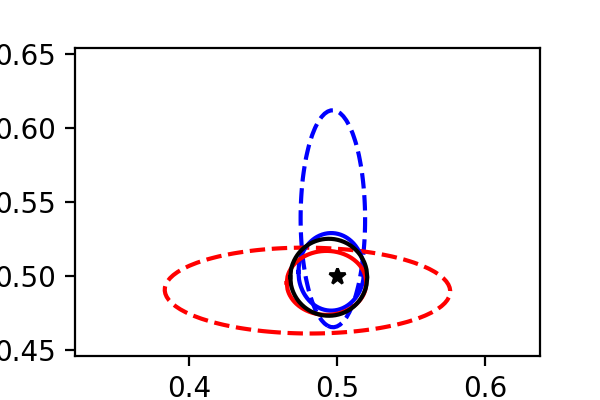

In [30]:
fig, ax = plt.subplots(figsize=figsize)

# Plot the true value of theta
plt.plot(theta_0[0], theta_1[1], 'k*')

# Plot contours of log-likelihood for example systems 
plt.contour(ll_image_0.transpose(), origin='lower', extent=extent, levels=levels_0, colors='b', linestyles='dashed')
plt.contour(ll_image_1.transpose(), origin='lower', extent=extent, levels=levels_1, colors='r', linestyles='dashed')
plt.plot(ellipse_q_0[:,0], ellipse_q_0[:,1], 'b-')
plt.plot(ellipse_q_1[:,0], ellipse_q_1[:,1], 'r-')
plt.plot(ellipse_mcpd[:,0], ellipse_mcpd[:,1], 'k-')
plt.xlabel('$theta_0$')
plt.ylabel('$theta_1$')
plt.axis('equal')

fig.savefig(save_loc, format='eps')